In [1]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


# Import Libraries

In [2]:
import os
import cv2
import shutil
import imutils
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import normalize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam,RMSprop

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# IGNORING UNNECESSARRY WARNINGS
from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

2024-07-21 16:20:55.169616: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 16:20:55.169675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 16:20:55.171204: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load dataset

In [3]:
base_dir = '/kaggle/input/classification-dataset/healthy_and_tumor'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Load images and labels to numpy arrays

In [4]:
def load_images_and_labels(base_dir, labels, color_mode='rgb'):
    x_train, y_train = [], []
    x_val, y_val = [], []
    x_test, y_test = [], []

    for label in labels:
        # Load training images
        train_dir = os.path.join(base_dir, 'train', label)
        for img_name in os.listdir(train_dir):
            img_path = os.path.join(train_dir, img_name)
            if color_mode == 'grayscale':
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            else:
                img = cv2.imread(img_path)
            if img is not None:
                img = cv2.bilateralFilter(img, 2, 50, 50)
                if color_mode == 'grayscale':
                    img = np.expand_dims(img, axis=-1)  # Add channel dimension
                x_train.append(img)
                y_train.append(labels.index(label))

        # Load validation images
        val_dir = os.path.join(base_dir, 'validation', label)
        for img_name in os.listdir(val_dir):
            img_path = os.path.join(val_dir, img_name)
            if color_mode == 'grayscale':
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            else:
                img = cv2.imread(img_path)
            if img is not None:
                img = cv2.bilateralFilter(img, 2, 50, 50)
                if color_mode == 'grayscale':
                    img = np.expand_dims(img, axis=-1)  # Add channel dimension
                x_val.append(img)
                y_val.append(labels.index(label))

        # Load test images
        test_dir = os.path.join(base_dir, 'test', label)
        for img_name in os.listdir(test_dir):
            img_path = os.path.join(test_dir, img_name)
            if color_mode == 'grayscale':
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            else:
                img = cv2.imread(img_path)
            if img is not None:
                img = cv2.bilateralFilter(img, 2, 50, 50)
                if color_mode == 'grayscale':
                    img = np.expand_dims(img, axis=-1)  # Add channel dimension
                x_test.append(img)
                y_test.append(labels.index(label))

    # Convert lists to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_val = np.array(x_val)
    y_val = np.array(y_val)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    return x_train, y_train, x_val, y_val, x_test, y_test

In [5]:
labels = ['healthy', 'tumor']

x_train, y_train, x_val, y_val, x_test, y_test = load_images_and_labels(base_dir, labels, color_mode='rgb')

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (2100, 224, 224, 3)
y_train shape: (2100,)
x_val shape: (450, 224, 224, 3)
y_val shape: (450,)
x_test shape: (450, 224, 224, 3)
y_test shape: (450,)


# Shuffle data

In [6]:
# Shuffle the training data
train_indices = np.arange(x_train.shape[0])
np.random.shuffle(train_indices)
x_train = x_train[train_indices]
y_train = y_train[train_indices]

# Shuffle the validation data
val_indices = np.arange(x_val.shape[0])
np.random.shuffle(val_indices)
x_val = x_val[val_indices]
y_val = y_val[val_indices]

# Shuffle the test data
test_indices = np.arange(x_test.shape[0])
np.random.shuffle(test_indices)
x_test = x_test[test_indices]
y_test = y_test[test_indices]

# Visualise data

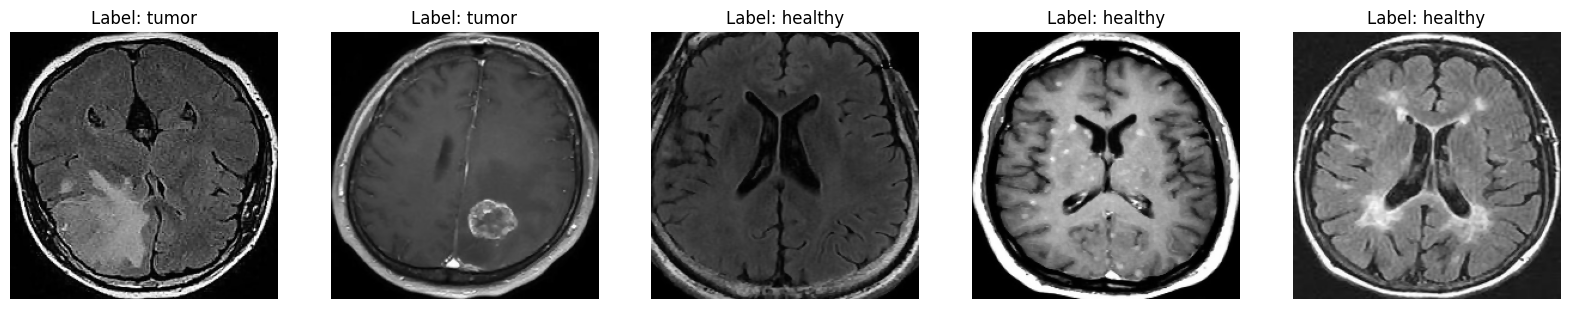

In [7]:
def display_sample_images(x, y, labels, num_samples=5):
    plt.figure(figsize=(20, 10))
    indices = np.random.choice(np.arange(x.shape[0]), num_samples, replace=False)
    for i, index in enumerate(indices):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(x[index], cv2.COLOR_BGR2RGB))  # Convert BGR (OpenCV) to RGB (Matplotlib)
        plt.title(f"Label: {labels[y[index]]}")
        plt.axis("off")
    plt.show()

display_sample_images(x_train, y_train, labels)

# Data shape and class distribution

In [8]:
# Check the shapes of the datasets
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

# Check the distribution of classes
print(f"Training labels distribution: {np.bincount(y_train)}")
print(f"Validation labels distribution: {np.bincount(y_val)}")

# Ensure the data is normalized
print(f"Training data range: {x_train.min()} to {x_train.max()}")
print(f"Validation data range: {x_val.min()} to {x_val.max()}")
print(f"Test data range: {x_test.min()} to {x_test.max()}")

x_train shape: (2100, 224, 224, 3)
y_train shape: (2100,)
x_val shape: (450, 224, 224, 3)
y_val shape: (450,)
Training labels distribution: [1050 1050]
Validation labels distribution: [225 225]
Training data range: 0 to 255
Validation data range: 0 to 255
Test data range: 0 to 255


# Data normalisation

Note: The train and validation data are normalised during data augmentation

In [9]:
x_test = x_test / 255.0

# Ensure the data is normalized
print(f"Training data range: {x_train.min()} to {x_train.max()}")
print(f"Validation data range: {x_val.min()} to {x_val.max()}")
print(f"Test data range: {x_test.min()} to {x_test.max()}")

Training data range: 0 to 255
Validation data range: 0 to 255
Test data range: 0.0 to 1.0


# Helper functions for model evaluation

In [10]:
def plot_training_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
def evaluate_validation_set(model,generator,steps):
    # Evaluate the model on the validation set
    validation_loss, validation_acc = model.evaluate(generator, steps=steps)
    print(f"Validation loss: {validation_loss}")
    print(f"Validation accuracy: {validation_acc}")
    
def evaluate_test_set(model,x_test,y_test):
    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(x_test,y_test)
    print(f"Test loss: {test_loss}")
    print(f"Test accuracy: {test_acc}")
    
def plot_pred_imgs(number_images,x_test,y_test,model):
    # Choose some random images from the test set
    num_images = number_images
    random_indices = np.random.choice(len(x_test), size=num_images, replace=False)
    sample_images = x_test[random_indices]
    sample_labels_true = y_test[random_indices]

    # Predict labels for the sample images
    sample_predictions = model.predict(sample_images)
    sample_labels_pred = (sample_predictions > 0.5).astype(int).flatten()

    # Define class labels (assuming binary classification)
    class_labels = ['healthy', 'tumor']

    # Plot the sample images with true and predicted labels
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(sample_images[i])
        plt.title(f"True: {class_labels[sample_labels_true[i]]}\nPred: {class_labels[sample_labels_pred[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
def plot_cm(model,x_test,y_test):
    # Assuming you have predictions on the test set already
    test_predictions = model.predict(x_test)
    test_pred_classes = (test_predictions > 0.5).astype(int).flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, test_pred_classes)
    
    # Define class labels
    class_labels = ['healthy', 'tumor'] # healthy=0, tumor=1

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
def plot_class_report(model,x_test,y_test):
    # Assuming you have predictions on the test set already
    test_predictions = model.predict(x_test)
    test_pred_classes = (test_predictions > 0.5).astype(int).flatten()

    # Define class labels
    class_labels = ['healthy', 'tumor']

    # Generate classification report
    report = classification_report(y_test, test_pred_classes, target_names=class_labels)

    print("Classification Report:\n", report)

def run_model(model,train_generator,steps_per_epoch,epochs,val_generator,validation_steps):
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=validation_steps
    )
    return history

def save_model(model, name):
    model.save(f'{name}.h5')

# Data Augmentation Example

Shown in 'data_augmentation_example.ipynb'.

In [ ]:
plt.imshow(x_train[1])
print(y_train[1])

In [ ]:
directory = 'preview'

# Check if the directory already exists
if os.path.exists(directory):
    print(f"Directory '{directory}' already exists. Deleting it...")
    shutil.rmtree(directory)  # Remove the directory and its contents recursively
    print(f"Directory '{directory}' deleted.")

# Create the directory
print(f"Creating directory '{directory}'...")
os.mkdir(directory)
print(f"Directory '{directory}' created.")

In [ ]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [ ]:
sample_x = x_train[1]  
sample_x = sample_x.reshape((1,) + sample_x.shape) 

i = 0
for batch in demo_datagen.flow(sample_x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

In [ ]:
plt.imshow(x_train[1])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

# Apply data augmentation

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(x_train, y_train, batch_size=32)

# Create a generator for the validation data (without augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow(x_val, y_val, batch_size=32)

# Classification model

In [12]:
def model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()
    return model

In [13]:
model = model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,679,041 (36.92 MB)

 Trainable params: 9,679,041 (36.92 MB)

 Non-trainable params: 0 (0.00 B)

# Compile and train model

In [14]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.0001),metrics=['acc'])

In [15]:
history = run_model(model,train_generator,100,50,val_generator,50)

Epoch 1/50


2024-07-21 16:21:12.211289: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49284: 7.84353, expected 6.92193
2024-07-21 16:21:12.211344: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49286: 7.76792, expected 6.84632
2024-07-21 16:21:12.211359: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49287: 6.15631, expected 5.23472
2024-07-21 16:21:12.211379: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49288: 6.71859, expected 5.797
2024-07-21 16:21:12.211398: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49289: 7.43913, expected 6.51753
2024-07-21 16:21:12.211410: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49290: 7.1783, expected 6.25671
2024-07-21 16:21:12.211421: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49291: 6.06838, expected 5.14679
2024-07-21 16:21:12.211431: E 

  1/100 ━━━━━━━━━━━━━━━━━━━━ 16:32 10s/step - acc: 0.5312 - loss: 0.7043

I0000 00:00:1721578877.492376     366 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  3/100 ━━━━━━━━━━━━━━━━━━━━ 17s 185ms/step - acc: 0.5069 - loss: 0.7802

2024-07-21 16:21:18.715442: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.63812, expected 5.86815
2024-07-21 16:21:18.715510: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.57545, expected 5.80549
2024-07-21 16:21:18.715527: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 6.58905, expected 5.81908
2024-07-21 16:21:18.715541: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.3889, expected 5.61894
2024-07-21 16:21:18.715551: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 6.23839, expected 5.46843
2024-07-21 16:21:18.715562: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.97291, expected 4.20294
2024-07-21 16:21:18.715572: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 5.35322, expected 4.58326
2024-07-21 16:21:18.715583: E external/local_xla/xla/

 65/100 ━━━━━━━━━━━━━━━━━━━━ 12s 363ms/step - acc: 0.5261 - loss: 0.7102

2024-07-21 16:21:41.712199: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 3.4831, expected 2.95098
2024-07-21 16:21:41.712261: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 28: 4.12173, expected 3.58961
2024-07-21 16:21:41.712270: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 62: 4.27148, expected 3.73936
2024-07-21 16:21:41.712278: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 66: 3.80207, expected 3.26995
2024-07-21 16:21:41.712286: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 83: 3.95449, expected 3.42237
2024-07-21 16:21:41.712294: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 85: 4.14698, expected 3.61486
2024-07-21 16:21:41.712303: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180: 3.99831, expected 3.46619
2024-07-21 16:21:41.712310: E external/local_xla

100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 251ms/step - acc: 0.5341 - loss: 0.7044 - val_acc: 0.5000 - val_loss: 0.6924
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 202ms/step - acc: 0.6135 - loss: 0.6677 - val_acc: 0.7333 - val_loss: 0.5881
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - acc: 0.6516 - loss: 0.6337 - val_acc: 0.7489 - val_loss: 0.5201
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 205ms/step - acc: 0.7088 - loss: 0.5941 - val_acc: 0.7756 - val_loss: 0.4776
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 203ms/step - acc: 0.7517 - loss: 0.5524 - val_acc: 0.8022 - val_loss: 0.4610
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - acc: 0.7695 - loss: 0.5266 - val_acc: 0.8356 - val_loss: 0.4210
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - acc: 0.7662 - loss: 0.5065 - val_acc: 0.8178 - val_loss: 0.4346
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - acc: 0.7756 - loss: 0.5001 - val_acc: 0.8444 - val_loss: 0.3919
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s

# Model evaluation

## Learning curve

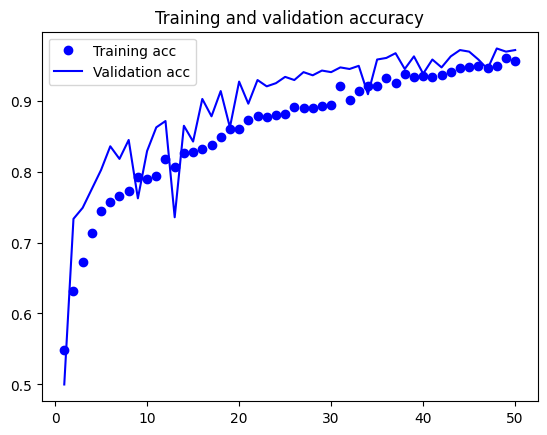

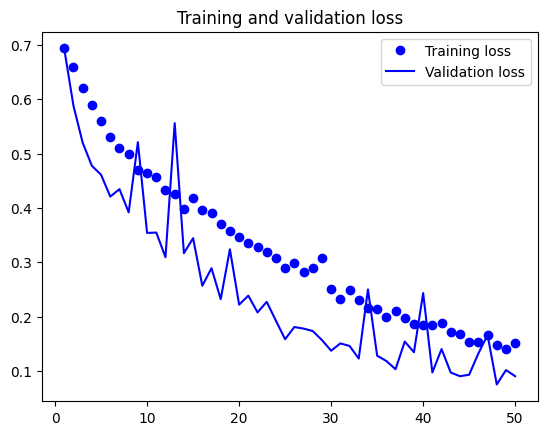

In [16]:
plot_training_curve(history)

## Validation and test set results

In [17]:
evaluate_validation_set(model,val_generator,50)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9738 - loss: 0.0828 
Validation loss: 0.09034838527441025
Validation accuracy: 0.9711111187934875


In [18]:
evaluate_test_set(model,x_test,y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.9786 - loss: 0.0540
Test loss: 0.05092335492372513
Test accuracy: 0.9800000190734863


## Qualitative analysis

2024-07-21 16:42:00.305825: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 7.29527, expected 6.30731
2024-07-21 16:42:00.305893: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 8.30394, expected 7.31598
2024-07-21 16:42:00.305902: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 8.1388, expected 7.15084
2024-07-21 16:42:00.305910: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.28868, expected 5.30072
2024-07-21 16:42:00.305918: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.24086, expected 5.25291
2024-07-21 16:42:00.305926: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.99145, expected 6.00349
2024-07-21 16:42:00.305934: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 7.16976, expected 6.18181
2024-07-21 16:42:00.305942: E external/local_xla/xla/ser

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step


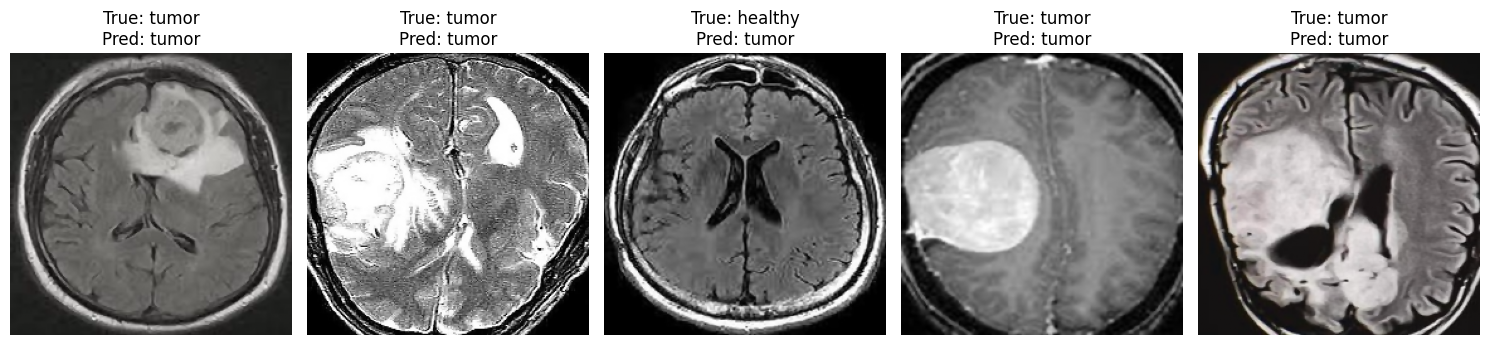

In [19]:
plot_pred_imgs(5,x_test,y_test,model)

## Confusion matrix

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


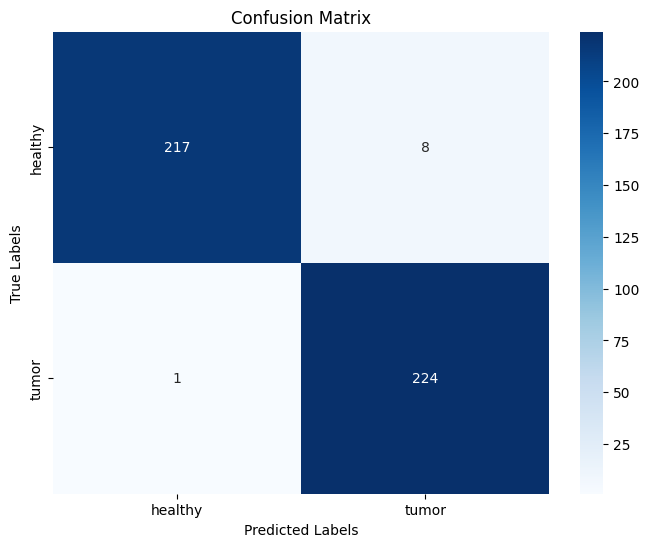

In [20]:
plot_cm(model,x_test,y_test)

## Classification report

In [21]:
plot_class_report(model,x_test,y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       1.00      0.96      0.98       225
       tumor       0.97      1.00      0.98       225

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [22]:
save_model(model,'classification_50_epoch')

# Test model on unseen data 

Note: This data is NOT test set, it is a seperate data which came with the dataset in the folder 'pred'.

Pipeline steps:
* Load model
* Crop and process input image
* Make prediction

In [23]:
# Load your trained model
model = load_model('/kaggle/working/classification_50_epoch.h5')

In [24]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions and dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # Crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In [33]:
pred_img = cv2.imread('/kaggle/input/brain-tumor-detection/pred/pred0.jpg')
pred_img = crop_brain_contour(pred_img,False)
pred_img = cv2.resize(pred_img,dsize=(224, 224),interpolation=cv2.INTER_CUBIC)
pred_img = cv2.bilateralFilter(pred_img, 2, 50, 50)

## Visual of test image

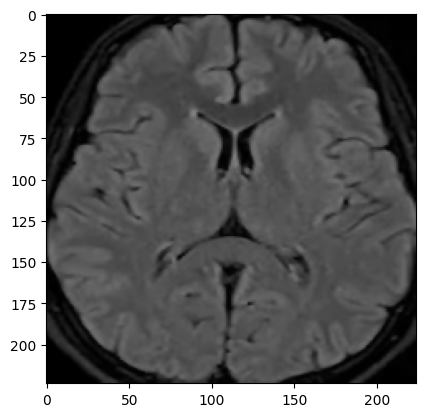

In [34]:
plt.imshow(pred_img)

# Conversion to numpy array and apply normalisation

In [35]:
pred_img = np.array(pred_img)
pred_img = np.expand_dims(pred_img, axis=0)
pred_img = pred_img / 255.0

## Model prediction

In [36]:
# Make prediction
predictions = model.predict(pred_img)

# Convert to binary predictions
pred = (predictions > 0.5).astype(int).flatten()

# Output the result
if pred[0] == 1:
    print('Tumor detected')
else:
    print('No tumor detected')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
No tumor detected
